In [1]:
import pandas as pd

columns = ["training",   # Treatment assignment indicator
           "age",        # Age of participant
           "education",  # Years of education
           "black",      # Indicate whether individual is black
           "hispanic",   # Indicate whether individual is hispanic
           "married",    # Indicate whether individual is married
           "no_degree",  # Indicate if individual has no high-school diploma
           "re74",       # Real earnings in 1974, prior to study participation
           "re75",       # Real earnings in 1975, prior to study participation
           "re78"]       # Real earnings in 1978, after study end

treated = pd.read_csv("http://www.nber.org/~rdehejia/data/nswre74_treated.txt", 
                      delim_whitespace=True, header=None, names=columns)
control = pd.read_csv("http://www.nber.org/~rdehejia/data/nswre74_control.txt",
                      delim_whitespace=True, header=None, names=columns)
lalonde = pd.concat([treated, control], ignore_index=True)
lalonde = lalonde.sample(frac=1.0, random_state=42)  # Shuffle

print(lalonde.shape)
lalonde.head()

(445, 10)


,training,age,education,black,hispanic,married,no_degree,re74,re75,re78
284,0.0,28.0,12.0,1.0,0.0,1.0,0.0,0.000,0.0000,0.0000
358,0.0,19.0,11.0,1.0,0.0,0.0,1.0,1626.623,0.0000,0.0000
117,1.0,20.0,12.0,1.0,0.0,0.0,0.0,0.000,377.5686,1652.6370
412,0.0,25.0,11.0,1.0,0.0,0.0,1.0,15209.990,3072.7260,284.6584
70,1.0,27.0,9.0,1.0,0.0,0.0,1.0,0.000,0.0000,0.0000


In [2]:
lalonde = lalonde.join((lalonde[["re74", "re75"]] == 0).astype(int), rsuffix=("=0"))
lalonde.head()

,training,age,education,black,hispanic,married,no_degree,re74,re75,re78,re74=0,re75=0
284,0.0,28.0,12.0,1.0,0.0,1.0,0.0,0.000,0.0000,0.0000,1,1
358,0.0,19.0,11.0,1.0,0.0,0.0,1.0,1626.623,0.0000,0.0000,0,1
117,1.0,20.0,12.0,1.0,0.0,0.0,0.0,0.000,377.5686,1652.6370,1,0
412,0.0,25.0,11.0,1.0,0.0,0.0,1.0,15209.990,3072.7260,284.6584,0,0
70,1.0,27.0,9.0,1.0,0.0,0.0,1.0,0.000,0.0000,0.0000,1,1


In [3]:
lalonde = pd.get_dummies(lalonde, columns=["education"], drop_first=True)
print(lalonde.shape)
lalonde.head()

(445, 24)


,training,age,black,hispanic,married,no_degree,re74,re75,re78,re74=0,...,education_7.0,education_8.0,education_9.0,education_10.0,education_11.0,education_12.0,education_13.0,education_14.0,education_15.0,education_16.0
284,0.0,28.0,1.0,0.0,1.0,0.0,0.000,0.0000,0.0000,1,...,0,0,0,0,0,1,0,0,0,0
358,0.0,19.0,1.0,0.0,0.0,1.0,1626.623,0.0000,0.0000,0,...,0,0,0,0,1,0,0,0,0,0
117,1.0,20.0,1.0,0.0,0.0,0.0,0.000,377.5686,1652.6370,1,...,0,0,0,0,0,1,0,0,0,0
412,0.0,25.0,1.0,0.0,0.0,1.0,15209.990,3072.7260,284.6584,0,...,0,0,0,0,1,0,0,0,0,0
70,1.0,27.0,1.0,0.0,0.0,1.0,0.000,0.0000,0.0000,1,...,0,0,1,0,0,0,0,0,0,0


In [4]:
a = lalonde.pop("training")
y = lalonde.pop("re78")
X = lalonde
X.shape, a.shape, y.shape

((445, 22), (445,), (445,))

In [5]:
from sklearn.linear_model import LogisticRegression

learner = LogisticRegression(penalty='none',  # No regularization, new in scikit-learn 0.21.*
                             solver='lbfgs',
                             max_iter=500)    # Increaed to achieve convergence with 'lbfgs' solver

C:\Users\39333\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
from causallib.estimation import IPW

ipw = IPW(learner)

C:\Users\39333\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\39333\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [9]:
ipw.fit(X, a)
outcomes = ipw.estimate_population_outcome(X, a, y)
effect = ipw.estimate_effect(outcomes[1], outcomes[0])
outcomes,effect

(0.0    4598.414070
 1.0    6141.051856
 dtype: float64,
 diff    1542.637786
 dtype: float64)

In [10]:
from causallib.estimation import MarginalOutcomeEstimator

moe = MarginalOutcomeEstimator(None).fit(X, a, y)
outcomes = moe.estimate_population_outcome(X, a, y)
moe.estimate_effect(outcomes[1], outcomes[0])

diff    1794.342404
dtype: float64

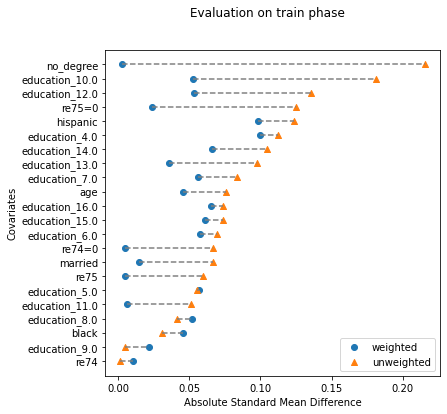

In [11]:
%matplotlib inline
from causallib.evaluation import PropensityEvaluator

evaluator = PropensityEvaluator(ipw)
evaluation_results = evaluator.evaluate_simple(X, a, y, plots=["covariate_balance_love"])

fig = evaluation_results.plots["covariate_balance_love"].get_figure()
fig.set_size_inches(6, 6)  # set a more compact size than default
fig;